# Full Code Final Version
This script will contain the full code for the SU2 local mesh refinement as part of the Bachelor End Project on local mesh refenement by F.C.J.L. van den Elzen, under supervision of dr. ir. N.A. Beishuizen.<br>

(c) F.C.J.L. van den Elzen (13-04-2022)

**Installing the correct packages** <br>
To connect Paraview with Python some additional packages might need to be installed. This only needs to be done once, then they can be commented out. See the two lines of code below.

In [1]:
#conda install -c anaconda vtk

In [2]:
#pip install pyvistaqt

**Importing the required packages** <br>
The packages below need to be loaded in for the rest of the code to work.

In [3]:
import numpy as np
import pyvista as pv
from pyvista import examples
import vtk
import scipy.stats as stats
from scipy.stats import norm
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import pyvistaqt as pvqt
import math
import os
import time
import ipywidgets as widgets
from IPython.display import display
from IPython.display import Markdown
import tkinter
from tkinter import *

**Creating the pop up window** <br>
If the cell below has been set to run a popup window will show, in which the required variables can be entered by the user. 

In [4]:
window = tkinter.Tk()
window.geometry("900x800")
window.title("Local Mesh Refinement")

entry = tkinter.StringVar(window)
entry_su2 = tkinter.StringVar(window)
entry_new = tkinter.StringVar(window)

data_variable_menu = tkinter.StringVar(window)  
data_variable_menu.set('*Select Refinement Variable*') 
option_menu = tkinter.StringVar(window)  
option_menu.set('*Select Refinement Margin*') 
slider_var = tkinter.DoubleVar(window)
gradient = IntVar(window)

def confirm():
    global flow_file,mesh_file, pd, drop
    flow_file = entry.get()
    mesh_file = entry_su2.get()
    Label(window, text=('Confirmed:',flow_file)).pack()
    Label(window, text=('Confirmed:',mesh_file)).pack()
    pd = pv.read(flow_file)      
    Label(window, text=('Please choose the data variable you wish to use for the refinement. Be aware, not all variable may be present in your .vtu file')).pack()
    drop = OptionMenu(window, data_variable_menu, 'Density', 'Energy','Heat_Flux', 'Laminar_Viscosity', 'Mach',  'MomentumX', 'MomentumY', 'Pressure', 'Pressure_Coefficient', 'Temperature', 'VelocityX', 'VelocityY').pack(pady=5)
    Checkbutton(window, text="Gradient", variable=gradient).pack()
    confirm_button_data = Button(window, 
                        text='Confirm Data Variable', 
                        command=confirm_data
                       ).pack()
    
    
    
def confirm_data():
    global data_variable, gradient_check
    data_variable = str(data_variable_menu.get()) 
    gradient_check = gradient.get()
    if data_variable == 'MomentumX':
        pd['MomentumX']=pd['Momentum'][:,0]
    elif data_variable == 'MomentumY':
        pd['MomentumY']=pd['Momentum'][:,1]
        
    if data_variable == 'Velocity':
        pd['VelocityX']=pd['Velocity'][:,0]
    elif data_variable == 'Velocity':
        pd['VelocityY']=pd['Velocity'][:,1]        
        
    Label(window, text=('Confirmed:',data_variable)).pack()
    Label(window, text=('Please choose the refinement margin you wish to use for the refinement')).pack()
    drop_margin = OptionMenu(window, option_menu, '*Select Refinement Margin*', 'Maximum Percentage','Minimum Percentage','Maximum Value', 'Minimum Value').pack(pady=5)

    confirm_button_margin = Button(window, 
                        text='Confirm Refinement Margin', 
                        command=confirm_margin
                       ).pack()

def confirm_margin():
    global Option
    Option = str(option_menu.get())
    Label(window, text=('Confirmed:',Option)).pack()
    
    if gradient_check == 0:
        if Option == 'Maximum Percentage' or Option == 'Minimum Percentage':
            Label(window, text=('Please choose the percentage you wish to use for the refinement')).pack()
            percentage = Scale(window, variable = slider_var, from_=0, to=100,length=600,tickinterval=10,orient=HORIZONTAL).pack()
        elif Option == 'Maximum Value' or Option == 'Minimum Value':
            Label(window, text=('Please choose the value you wish to use for the refinement')).pack()
            value = Scale(window, variable = slider_var, from_=pd[data_variable].min(), to=pd[data_variable].max(),length=600,tickinterval=10,orient=HORIZONTAL).pack()

            
    elif gradient_check == 1:
        if Option == 'Maximum Percentage' or Option == 'Minimum Percentage':
            Label(window, text=('Please choose the percentage you wish to use for the refinement')).pack()
            percentage = Scale(window, variable = slider_var, from_=0, to=100,length=600,tickinterval=10,orient=HORIZONTAL).pack()
        elif Option == 'Maximum Value' or Option == 'Minimum Value':
            Label(window, text=('Please choose the value you wish to use for the refinement')).pack()
            value = Scale(window, variable = slider_var, from_=np.gradient(pd[data_variable]).min(), to=np.gradient(pd[data_variable]).max(),length=600,tickinterval=10,orient=HORIZONTAL).pack()

    confirm_button_value = Button(window, 
                        text='Confirm Refinement Margin Value', 
                        command=enter_new_file
                       ).pack()
    
def enter_new_file():
    global slider_value
    slider_value = slider_var.get()  
    Label(window, text=('Confirmed:',slider_value)).pack()
    Label(window, text=('Please enter the file location and name you wish to use for the refinement \n (example: C:/Users/20192167/Documents/Boeken/BEP/SU2-master/SU2-master/QuickStart/mesh_new.su2')).pack()
        
    entry_mesh_file_new = Entry(window, 
                        textvariable = entry_new,
                        width=100).pack(pady=10)
    
    exit_button = Button(window, 
                         text='Extract New Mesh File', 
                         command=close_window
                        ).pack(pady=20)
def close_window():
    global new_name
    new_name = entry_new.get()
    window.destroy()     

greeting = Label(text="Welcome.\n Please enter the location of the flow file. \n (example: C:/Users/20192167/Documents/Boeken/BEP/SU2-master/SU2-master/QuickStart/flow.vtu").pack()

entry_flow_file = Entry(window, 
                        textvariable = entry,
                        width=100).pack(pady=10)
Label(text='Please enter the location of the mesh file. \n(example: C:/Users/20192167/Documents/Boeken/BEP/SU2-master/SU2-master/QuickStart/mesh_NACA0012_inv.su2').pack()

entry_mesh_file = Entry(window, 
                        textvariable = entry_su2,
                        width=100).pack(pady=10)

confirm_button = Button(window, 
                        text='Confirm File Locations', 
                        command=confirm
                       ).pack()

##############################################################

    
##############################################################
window.mainloop()

**Sorting the data per cell** (Example Temperature) <br>
To make sure that the correct cells can be indicated an average per cell will be calculated. 'data_variable' indicated the variable you wish to base your local mesh refinement on. 

In [5]:
cells=pd.cells
points=pd.points

Centers = []
cellsC = cells
C = []

while True:
    if cellsC[0]==3:
        a = cellsC[1]
        b = cellsC[2]
        c = cellsC[3]

        C = (pd[data_variable][a]+pd[data_variable][b] +pd[data_variable][c])/3
        Centers.append(C)
        cellsC = cellsC[4:]

    elif cellsC[0]==4:
        a = cellsC[1]
        b = cellsC[2]
        c = cellsC[3]
        d = cellsC[4]

        C = (pd[data_variable][a]+pd[data_variable][b] +pd[data_variable][c]+pd[data_variable][d])/4
        Centers.append(C)
        cellsC = cellsC[5:]

    if len(cellsC) == 0:
        break
        
if gradient_check == 1:
    Centers_new = np.gradient(Centers)
    Centers=Centers_new

**Determining which cells should be refined** <br>
Based on the visualizations above the user can determine the variable on which the local mesh refinement should be based. Then the code below can be used to for filter the cells based on that data variable. This can be done with a minimum or maximum value filter or with a minimum or maximum percentage filter. 

In [6]:
Index = []
Centers_ordered = Centers.copy()
Centers_ordered.sort()

if Option == 'Maximum Value':
    for x in range(0, len(Centers)):
        if Centers[x] <= slider_value:
            Index.append(x)
            
elif Option == 'Minimum Value':
    for x in range(0, len(Centers)):
        if Centers[x] >= slider_value:
            Index.append(x)
            
elif Option == 'Maximum Percentage':
    margin = np.percentile(Centers_ordered, slider_value)
    
    for x in range(0, len(Centers)):
        if Centers[x] > margin:
            Index.append(x)
            
elif Option == 'Minimum Percentage':
    margin = np.percentile(Centers_ordered, slider_value)

    for x in range(0, len(Centers)):
        if Centers[x] < margin:
            Index.append(x)

**Loading in the SU2 mesh file** <br>
Next the original SU2 mesh file will be loaded into Python. It will detect whether it is a square or triangular mesh. Additionally, the code will be prepared for processing.

In [7]:
f = open(mesh_file, 'r')


# first get the dimensions
line = f.readline()
columns = line.split()
print(columns)

NDIME = columns[1]
print("dimensions = ",NDIME)

# then, get the nr of elements
line = f.readline()
columns = line.split()

NELEM=columns[1]
print("nr of elements=",NELEM)

connectivity = []
Type = []
offset = []
i = 0

for x in range(0, int(NELEM)):
    line=f.readline()
    columns = line.split()
    meshtype=int(columns[0])
    
    if meshtype == 5:
        connectivity.append(int(3))
        connectivity.append(int(columns[1]))
        connectivity.append(int(columns[2]))
        connectivity.append(int(columns[3]))
        Type.append(3)
        offset.append(i)
        i = i + 4
    
    elif meshtype == 9:
        connectivity.append(int(4))
        connectivity.append(int(columns[1]))
        connectivity.append(int(columns[2]))
        connectivity.append(int(columns[3]))
        connectivity.append(int(columns[4]))
        Type.append(4)
        offset.append(i)
        i = i + 5


print("end reading elements")
# then, get the coordinates
line = f.readline()
columns = line.split()

NPOIN=columns[1]
print("nr of points=",NPOIN)

# create the 2D point array
points = np.arange(2*int(NPOIN),dtype=np.float64).reshape(int(NPOIN),2)
# now, read all the points into a structure
for i in range(int(NPOIN)):
    line=f.readline()
    columns = line.split()
    points[i][0]=float(columns[0])
    points[i][1]=float(columns[1])

# now, read the markers
line = f.readline()
columns = line.split()

NMARK=columns[1]
print("nr of markers=",NMARK)

# name of the marker (list of strings)
markername = []
# number of elements in the marker (list of integers)
markerelements = np.arange(int(NMARK),dtype=np.int32)
# this is the list of numpy arrays
markers = []

# list of marker points
markerpointslist = []

for m in range(int(NMARK)):
    line = f.readline()
    columns = line.split()
    markername.append(columns[1])
    print(" ",m,": marker name=",markername[m])
    line = f.readline()
    columns = line.split()
    markerelements[m] = int(columns[1])   
    print(" marker elements=",markerelements[m])
    markerarray = np.arange(2*int(markerelements[m])).reshape(int(markerelements[m]),2)

    for i in range(int(markerelements[m])):
        line=f.readline()
        columns = line.split()
        markerarray[i][0]=columns[1]
        markerarray[i][1]=columns[2]
        
    # now add the array to the list of markers
    markers.append(markerarray)

print("Finished reading su2 file.") 

['NDIME=', '2']
dimensions =  2
nr of elements= 13213
end reading elements
nr of points= 12876
nr of markers= 3
  0 : marker name= left
 marker elements= 31
  1 : marker name= right
 marker elements= 31
  2 : marker name= wall
 marker elements= 720
Finished reading su2 file.


In [8]:
cells=connectivity

In [9]:
n = int(NPOIN)
z = np.zeros((n, 1))
p = np.append(points, z, axis=1)
points = p
points

array([[ 0.        ,  0.        ,  0.        ],
       [ 0.0012    ,  0.0001    ,  0.        ],
       [ 0.00134142,  0.0001    ,  0.        ],
       ...,
       [ 0.00247342, -0.00113454,  0.        ],
       [ 0.00247429, -0.00113367,  0.        ],
       [ 0.00249249, -0.00115187,  0.        ]])

In [10]:
markers0 = markers.copy()

**Visualizing the mesh with Paraview** <br>
The original mesh will be visualized with Paraview to later confirm the refinement of the desired cells.

In [11]:
mesh = pv.PolyData(points, connectivity)
pl = pvqt.BackgroundPlotter()
pl.add_mesh(mesh, show_edges=True, line_width=0.05, color='#EEEEEE')
pl.set_background('white')
#pl.add_point_labels(points, [f'Point {i}' for i in range(5)],always_visible=True,
#                    font_size=20,text_color='white', point_size=20,point_color='red',render_points_as_spheres=True)
pl.camera_position = 'xy'
pl.show()

**Mesh Quality of the original mesh** <br>
Before refining the mesh, the mesh quality of the original mesh will be determined.

In [12]:
cells_quality=cells.copy()

aspect_ratio = []
Skewness = []
Orthogonality = []

for y in range(0, len(Type)):
    if cells_quality[0] == 3: #If the mesh is triangular
        z1 = 3
        z2 = 5
        qe = 60
        p = [points[cells_quality[1]],points[cells_quality[2]],points[cells_quality[3]]]
    
    elif cells_quality[0] == 4: #is the mesh is square
        z1 = 4
        z2 = 6
        qe = 90
        z3 = 2
        p = [points[cells_quality[1]],points[cells_quality[2]],points[cells_quality[3]],points[cells_quality[4]]]
        
    #----------------------------------------------------------#
    #--------------------Aspect Ratio--------------------------#
    #----------------------------------------------------------#

    distance = [] #A temporary array containing the lenghts of the edges

    for z in range(0,z1):
        l = abs(p[z%z1]-p[(z+1)%z1]) # calculates the difference in x and y coordinates of the points
        d = math.sqrt(l[0]**2 + l[1]**2) # calculates the length of the edges
        distance.append(d)
        ar = min(distance)/max(distance)
        aspect_ratio.append(ar)
        
    #-----------------------------------------------------------#
    #-------------------------Skewness--------------------------#
    #-----------------------------------------------------------#
    if z1 ==3:
        a = distance[1]
        b = distance[2]
        c = distance[0]
        alpha = math.degrees(math.acos((a**2-b**2-c**2)/(-2*b*c))) #calculates the angles of the corners
        beta = math.degrees(math.acos((b**2-c**2-a**2)/(-2*c*a)))
        gamma = math.degrees(math.acos((c**2-b**2-a**2)/(-2*b*a)))
        qmin = min(alpha, beta, gamma) #determines the minimal angle
        qmax = max(alpha, beta, gamma) #determines the maximal angle

    elif z1 == 4:
        a = distance[0]
        b = distance[1]
        c = distance[2]
        d = distance[3]
        for z in range(0,z3):
            l = abs(p[z%z1]-p[(z+2)%z1]) # calculates the difference in x and y coordinates of the points
            d2 = math.sqrt(l[0]**2 + l[1]**2) # calculates the length of the edges
            distance.append(d2)
        e = distance[4]
        f = distance[5]
        
        alpha1 = math.degrees(math.acos((b**2-e**2-a**2)/(-2*e*a))) #calculates the angles of the corners
        alpha2 = math.degrees(math.acos((d**2-f**2-c**2)/(-2*f*c)))
        beta = math.degrees(math.acos((e**2-a**2-b**2)/(-2*a*b)))
        gamma1 = math.degrees(math.acos((a**2-e**2-b**2)/(-2*e*b)))
        gamma2 = math.degrees(math.acos((c**2-d**2-f**2)/(-2*d*f)))
        gamma = gamma2+alpha2
        alpha = gamma1+alpha1
        delta = math.degrees(math.acos((f**2-d**2-c**2)/(-2*d*c)))
        qmin = min(alpha, beta, gamma, delta) #determines the minimal angle
        qmax = max(alpha, beta, gamma, delta) #determines the maximal angle
    skewness = max((qmax-qe)/(180-qe), (qe-qmin)/qe) 
    Skewness.append(skewness)

    #--------------------------------------------------------------------#
    #------------------------Face Orthogonality--------------------------#
    #--------------------------------------------------------------------#

    if z1 ==3: #if triangle
        d = cells_quality[1]
        e = cells_quality[2]
        f = cells_quality[3]

        center = (p[0]+p[1]+p[2])/3
        point1 = ((points[e]+points[d])/2) #creating a additional point in the middle of the first edge of the side
        point2 = ((points[f]+points[e])/2) #creating a additional point in the middle of the second edge of the side
        point3 = ((points[d]+points[f])/2) #creating a additional point in the middle of the third edge of the side 

        e1= point1-center #center to point1
        e2= point2-center #center to point2
        e3= point3-center #center to point3
        vectors_e = [e1[:2],e2[:2],e3[:2]]

        v1= points[e]-points[d]
        v2= points[f]-points[e]
        v3= points[d]-points[f]

        #v=(a,b) u=(b,-a) #perpendicular
        A1= (v1[1],-v1[0]) #perpendicular to side de
        A2= (v2[1],-v2[0])#perpendicular to side ef
        A3= (v3[1],-v3[0])#perpendicular to side fd
        vectors_A=[A1,A2,A3]

        orth = []
        for o in range(0,3):
            dot_e_A = abs((vectors_A[o][0]*vectors_e[o][0])+(vectors_A[o][1]*vectors_e[o][1]))
            magnitude_e = math.sqrt((vectors_e[o][0])**2+(vectors_e[o][1])**2)
            magnitude_A = math.sqrt((vectors_A[o][0])**2+(vectors_A[o][1])**2)
            ort = (dot_e_A)/(magnitude_e*magnitude_A)
            orth.append(ort)
        Orthogonality.append(min(orth))


    elif z1==4: #if square

        d = cells_quality[1]
        e = cells_quality[2]
        f = cells_quality[3]
        g = cells_quality[4]

        center = (p[0]+p[1]+p[2]+p[3])/4
        point1 = ((points[e]+points[d])/2) #creating a additional point in the middle of the first edge of the side
        point2 = ((points[f]+points[e])/2) #creating a additional point in the middle of the second edge of the side
        point3 = ((points[g]+points[f])/2) #creating a additional point in the middle of the third edge of the side
        point4 = ((points[f]+points[d])/2) #creating a additional point in the middle of the third edge of the side

        e1= point1-center #center to point1
        e2= point2-center #center to point2
        e3= point3-center #center to point3
        e4= point4-center #center to point4
        vectors_e = [e1[:2],e2[:2],e3[:2], e4[:2]]

        v1= points[e]-points[d]
        v2= points[f]-points[e]
        v3= points[g]-points[f]
        v4= points[d]-points[g]

        #v=(a,b) u=(b,-a) #perpendicular
        A1= (v1[1],-v1[0]) #perpendicular to side de
        A2= (v2[1],-v2[0])#perpendicular to side ef
        A3= (v3[1],-v3[0])#perpendicular to side fg
        A4= (v4[1],-v4[0])#perpendicular to side gd
        vectors_A=[A1,A2,A3,A4]

        orth = []
        for o in range(0,4):
            dot_e_A = abs((vectors_A[o][0]*vectors_e[o][0])+(vectors_A[o][1]*vectors_e[o][1]))
            magnitude_e = math.sqrt((vectors_e[o][0])**2+(vectors_e[o][1])**2)
            magnitude_A = math.sqrt((vectors_A[o][0])**2+(vectors_A[o][1])**2)
            ort = (dot_e_A)/(magnitude_e*magnitude_A)
            orth.append(ort)
        Orthogonality.append(min(orth))

    if cells_quality[0] == 3: #If the mesh is triangular
        cells_quality=cells_quality[4:]
    elif cells_quality[0] == 4: #is the mesh is square
        cells_quality=cells_quality[5:]  

      
        
print('The average Aspect Ratio of the original mesh is', round(sum(aspect_ratio)/len(aspect_ratio),3))
print('The minimum Aspect Ratio of the original mesh is', round(min(aspect_ratio),3))
print('the maximum Aspect Ratio of the original mesh is', round(max(aspect_ratio),3))

print('The average Skewness of the original mesh is', round(sum(Skewness)/len(Skewness),3))
print('The minimum Skewness of the original mesh is', round(min(Skewness),3))
print('the maximum Skewness of the original mesh is', round(max(Skewness),3))

print('The average Face Orthogonality of the mesh is', round(sum(Orthogonality)/len(Orthogonality),3))
print('The minimum Face Orthogonality of the mesh is', round(min(Orthogonality),3))
print('The maximum Face Orthogonality of the mesh is', round(max(Orthogonality),3))      

C:\Users\20192167\AppData\Local\Temp/ipykernel_19584/2667322468.py:147: RuntimeWarning: invalid value encountered in double_scalars
  ort = (dot_e_A)/(magnitude_e*magnitude_A)


The average Aspect Ratio of the original mesh is 0.571
The minimum Aspect Ratio of the original mesh is 0.039
the maximum Aspect Ratio of the original mesh is 1.0
The average Skewness of the original mesh is 0.061
The minimum Skewness of the original mesh is 0.0
the maximum Skewness of the original mesh is 0.958
The average Face Orthogonality of the mesh is 0.759
The minimum Face Orthogonality of the mesh is 0.0
The maximum Face Orthogonality of the mesh is 1.0


C:\Users\20192167\Anaconda3\lib\site-packages\pyvista\jupyter\notebook.py:60: UserWarning: Failed to use notebook backend: 

Please install `ipyvtklink` to use this feature: https://github.com/Kitware/ipyvtklink

Falling back to a static output.
  warnings.warn(f'Failed to use notebook backend: \n\n{e}\n\n'


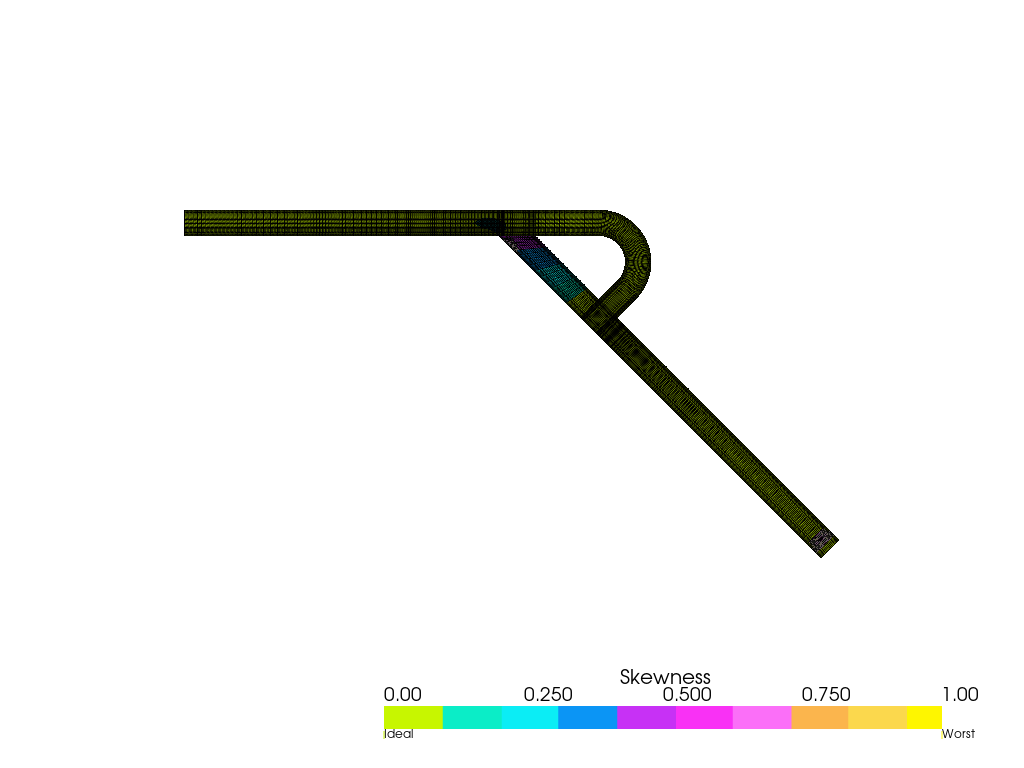

In [13]:
mesh.cell_data['Skewness']= Skewness

# Define the colors we want to use
green = np.array([200/256, 247/256, 0/256, 1])
greenblue = np.array([12/256, 238/256, 200/256, 1])
blue = np.array([12/256, 238/256, 246/256, 1])
darkblue = np.array([12/256, 150/256, 246/256, 1])
purple= np.array([200/256, 50/256, 246/256, 1])
pink= np.array([250/256, 50/256, 246/256, 1])
lightpink = np.array([250/256, 50/256, 246/256, 0.7])
orange = np.array([250/256, 150/256, 0/256, 0.7])
yelloworange = np.array([250/256, 200/256, 0/256, 0.7])
yellow = np.array([255/256, 247/256, 0/256, 1])
grey = np.array([189/256, 189/256, 189/256, 1])

skewness = np.linspace(mesh['Skewness'].min(), mesh['Skewness'].max(), 256)
newcolors = np.empty((256, 4))
newcolors[skewness >= 0] = green
#newcolors[skewness > 0.1] = lightgreen
newcolors[skewness > 0.1] = greenblue
newcolors[skewness > 0.2] = blue
newcolors[skewness > 0.3] = darkblue
newcolors[skewness > 0.4] = purple
newcolors[skewness > 0.5] = pink
newcolors[skewness > 0.6] = lightpink
newcolors[skewness > 0.7] = orange
newcolors[skewness > 0.8] = yelloworange
newcolors[skewness > 0.9] = yellow
newcolors[skewness >= 1] = grey

my_colormap = ListedColormap(newcolors)
annotations = {
    1: "Worst",
    0: "Ideal",
}

pl = pv.Plotter()
pl.set_background('white')
pv.global_theme.font.color = 'black'
pl.add_mesh(mesh, show_edges=True, line_width=0.5,scalars='Skewness',
            cmap=my_colormap, annotations=annotations,clim=[0, 1])
pl.camera_position = 'xy'
pl.show()

**Refining the mesh** <br>


In [14]:
c = Index.copy()
c 

[2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 93,
 94,
 95,
 96,
 97,
 98,
 101,
 102,
 103,
 104,
 105,
 106,
 109,
 110,
 111,
 112,
 113,
 114,
 117,
 118,
 119,
 120,
 124,
 125,
 126,
 127,
 133,
 137,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177,
 178,
 182,
 183,
 184,
 185,
 186,
 187,
 188,
 189,
 193,
 194,
 195,
 196,
 197,
 198,
 199,
 204,
 205,
 206,
 207,
 208,
 209,
 213,
 214,
 215,
 216,
 217,
 218,
 222,
 223,
 224,
 237,
 238,
 241,
 242,
 243,
 246,
 247,
 248,
 251,
 252,
 253,
 256,
 257,
 258,
 261,
 262,
 263,
 266,
 267,
 268,
 271,
 272,
 275,
 2

In [15]:
t1 = time.time()

In [16]:
clen = len(c)
c_filtered=c.copy()

ytotal = []
ytotaly = []
#-----------------------------------------------------#
#------------Refining the square cells----------------#
#-----------------------------------------------------#
for cx in range(0,clen):
     
    if Type[c[cx]]==4:
        
        d1 = cells[offset[c[cx]]+1]
        d2 = cells[offset[c[cx]]+2]
        d3 = cells[offset[c[cx]]+3]
        d4 = cells[offset[c[cx]]+4]
        
        point1 = ((points[d3]+points[d1])/2) 
        points = np.vstack([points,point1]) #adding the points to the points array
    
        g = len(points) #the new total number of points
        
        cells[offset[c[cx]]] = 3
        cells[offset[c[cx]]+1]= d1
        cells[offset[c[cx]]+2]= d2
        cells[offset[c[cx]]+3]= (g-1)
        cells= np.delete(cells, [offset[c[cx]]+4],None)
        
        cells = np.append(cells,3)
        cells = np.append(cells,d2)
        cells = np.append(cells,d3)
        cells = np.append(cells,(g-1))
        
        cells = np.append(cells,3)
        cells = np.append(cells,d3)
        cells = np.append(cells,d4)
        cells = np.append(cells,(g-1))
        
        cells = np.append(cells,3)
        cells = np.append(cells,d4)
        cells = np.append(cells,d1)
        cells = np.append(cells,(g-1))
        
        Type[c[cx]]=3
        Type.append(3)
        Type.append(3)
        Type.append(3)
        
        for x in range(1, len(offset)-c[cx]):
            offset[c[cx]+x] = offset[c[cx]+x]-1
        
        offset.append(offset[-1]+Type[-4]+1)
        offset.append(offset[-1]+Type[-3]+1)
        offset.append(offset[-1]+Type[-2]+1)
        
        c_filtered[cx] = 'x'

#------------------------------------------------------------------------------#
#----------Creating a new list c with just triangular cells--------------------#
#------------------------------------------------------------------------------#
c_new = [] #a new list with all the triangular cells that should still be refined

for x in range(0, len(c_filtered)):      
    if c_filtered[x] !='x':
        c_new.append(c_filtered[x])

#-------------------------------------------------------------------------------#    
#--------Finding the neighbouring cells of the cells you wish to refine---------#
#-------------------------------------------------------------------------------#
for cx in range(0,len(c_new)):

    if Type[c_new[cx]]==3:
        d1 = cells[offset[c_new[cx]]+1]
        d2 = cells[offset[c_new[cx]]+2]
        d3 = cells[offset[c_new[cx]]+3]

        #--------------------------------------------#
        #------Finding neigbouring cells-------------#
        #--------------------------------------------#
        
        w = 0
        y=[]

        while True:
            if w >= len(Type):
                y.append(len(Type)+1)
                ytotaly.append(len(Type)+1)
                break
                
            if Type[w]==3:
                cell=[cells[offset[w]], cells[offset[w]+1],cells[offset[w]+2],cells[offset[w]+3]]
            elif Type[w]==4:
                cell=[cells[offset[w]], cells[offset[w]+1],cells[offset[w]+2],cells[offset[w]+3],cells[offset[w]+4]]

            if d1 in cell[1:] and d2 in cell[1:]:
                if w not in c_new:
                    y.append(w)
                    ytotaly.append(w)
                    break
                    
            w=w+1    
                
        w = 0
        while True:
            
            if w >= len(Type):
                y.append(len(Type)+1)
                ytotaly.append(len(Type)+1)
                break     
                
            if Type[w]==3:
                cell=[cells[offset[w]], cells[offset[w]+1],cells[offset[w]+2],cells[offset[w]+3]]
            elif Type[w]==4:
                cell=[cells[offset[w]], cells[offset[w]+1],cells[offset[w]+2],cells[offset[w]+3],cells[offset[w]+4]]
                    
            if d2 in cell[1:] and d3 in cell[1:]:
                if w not in c_new:
                    y.append(w)
                    ytotaly.append(w)
                    break    
            
            w = w+1
                
        w = 0   
        while True:
            
            if w >= len(Type):
                y.append(len(Type)+1)
                ytotaly.append(len(Type)+1)
                break  
                
            if Type[w]==3:
                cell=[cells[offset[w]], cells[offset[w]+1],cells[offset[w]+2],cells[offset[w]+3]]
            elif Type[w]==4:
                cell=[cells[offset[w]], cells[offset[w]+1],cells[offset[w]+2],cells[offset[w]+3],cells[offset[w]+4]]
                    
            if d3 in cell[1:] and d1 in cell[1:]:
                if w not in c_new:
                    y.append(w)
                    ytotaly.append(w)
                    break     

            w=w+1    
    

    ytotal.append(y)        

    
#-------------------------------------------------------------------------#
#---------Finding neighbouring cells that are called for twice------------#
#-------------------------------------------------------------------------#
i=0
c_new_len= len(c_new)
for x in range (0,len(ytotal)): #for every cell listed in {ytotal}
    for z in range(0,3): 
        if ytotal[x][z] in ytotaly[3+i:]: #if the cell is listed again in {ytotal}
            if ytotal[x][z] != len(Type)+1: #if it is not the additional cell added for no connection
                if ytotal[x] not in c_new: #if the cell is not listed in {c}
                    c_new.append(ytotal[x][z]) #add the cell to {c}
                    v =1
            else:
                v=0
        else:
            v =0

    i = i+3    

if c_new_len == len(c_new): #if at least two cells share the same neighbouring cell. The code will be ran again.
    a=1
else:
    a=0

    
while True:
    c_new_len = len(c_new)
    
    if a == 1:
        break
    
    ytotaly=[]
    ytotal = []
    c_filtered=c_new.copy()
    
    for cx in range(0,len(c_new)):

        if Type[c_new[cx]]==4:

            d1 = cells[offset[c-new[cx]]+1]
            d2 = cells[offset[c_new[cx]]+2]
            d3 = cells[offset[c_new[cx]]+3]
            d4 = cells[offset[c_new[cx]]+4]

            point1 = ((points[d3]+points[d1])/2) 
            points = np.vstack([points,point1]) #adding the points to the points array

            g = len(points) #the new total number of points

            cells[offset[c_new[cx]]] = 3
            cells[offset[c_new[cx]]+1]= d1
            cells[offset[c_new[cx]]+2]= d2
            cells[offset[c_new[cx]]+3]= (g-1)
            cells= np.delete(cells, [offset[c_new[cx]]+4],None)

            cells = np.append(cells,3)
            cells = np.append(cells,d2)
            cells = np.append(cells,d3)
            cells = np.append(cells,(g-1))

            cells = np.append(cells,3)
            cells = np.append(cells,d3)
            cells = np.append(cells,d4)
            cells = np.append(cells,(g-1))

            cells = np.append(cells,3)
            cells = np.append(cells,d4)
            cells = np.append(cells,d1)
            cells = np.append(cells,(g-1))

            Type[c_new[cx]]=3
            Type.append(3)
            Type.append(3)
            Type.append(3)

            for x in range(1, len(offset)-c_new[cx]):
                offset[c_new[cx]+x] = offset[c_new[cx]+x]-1

            offset.append(offset[-1]+Type[-4]+1)
            offset.append(offset[-1]+Type[-3]+1)
            offset.append(offset[-1]+Type[-2]+1)

            c_filtered[cx] = 'x'


    c_new = []
    for x in range(0, len(c_filtered)):      
        if c_filtered[x] !='x':
            c_new.append(c_filtered[x])
    
    for cx in range(0,len(c_new)):

        if Type[c_new[cx]]==3:
            d1 = cells[offset[c_new[cx]]+1]
            d2 = cells[offset[c_new[cx]]+2]
            d3 = cells[offset[c_new[cx]]+3]
            
            #--------------------------------------------#
            #------Finding neigbouring cells-------------#
            #--------------------------------------------#

            w = 0
            y=[]

            while True:
                
                if w >= len(Type):
                    y.append(len(Type)+1)
                    ytotaly.append(len(Type)+1)
                    break
                    
                if Type[w]==3:
                    cell=[cells[offset[w]], cells[offset[w]+1],cells[offset[w]+2],cells[offset[w]+3]]
                elif Type[w]==4:
                    cell=[cells[offset[w]], cells[offset[w]+1],cells[offset[w]+2],cells[offset[w]+3],cells[offset[w]+4]]

                if d1 in cell[1:] and d2 in cell[1:]:
                    if w not in c_new:
                        y.append(w)
                        ytotaly.append(w)
                        break

                w=w+1    

            w = 0
            while True:
                
                if w >= len(Type):
                    y.append(len(Type)+1)
                    ytotaly.append(len(Type)+1)
                    break
                    
                if Type[w]==3:
                    cell=[cells[offset[w]], cells[offset[w]+1],cells[offset[w]+2],cells[offset[w]+3]]
                elif Type[w]==4:
                    cell=[cells[offset[w]], cells[offset[w]+1],cells[offset[w]+2],cells[offset[w]+3],cells[offset[w]+4]]

                if d2 in cell[1:] and d3 in cell[1:]:
                    if w not in c_new:
                        y.append(w)
                        ytotaly.append(w)
                        break    

                w = w+1

            w = 0   
            while True:
                
                if w >= len(Type):
                    y.append(len(Type)+1)
                    ytotaly.append(len(Type)+1)
                    break
                    
                if Type[w]==3:
                    cell=[cells[offset[w]], cells[offset[w]+1],cells[offset[w]+2],cells[offset[w]+3]]
                elif Type[w]==4:
                    cell=[cells[offset[w]], cells[offset[w]+1],cells[offset[w]+2],cells[offset[w]+3],cells[offset[w]+4]]

                if d3 in cell[1:] and d1 in cell[1:]:
                    if w not in c_new:
                        y.append(w)
                        ytotaly.append(w)
                        break

                w=w+1    

            ytotal.append(y)        

    #-------------------------------------------------------------------------#
    #---------Finding neighbouring cells that are called for twice------------#
    #-------------------------------------------------------------------------#
    i=0
    
    for x in range (0,len(ytotal)): #for every cell listed in {ytotal}
        for z in range(0,3): 
            if ytotal[x][z] in ytotaly[3+i:]: #if the cell is listed again in {ytotal}
                if ytotal[x][z] != len(Type)+1: #if it is not the additional cell added for no connection
                    if ytotal[x] not in c_new: #if the cell is not listed in {c}
                        c_new.append(ytotal[x][z]) #add the cell to {c}
                        v =1
                else:
                    v=0
            else:
                v =0

        i = i+3    
        
    if c_new_len == len(c_new): #if at least two cells share the same neighbouring cell. The code will be ran again.
        break
            
#---------------------------------------------------------------#
#--------Determining which point the cells do not share---------#
#---------------------------------------------------------------#

r=[] #an array containing a 1 for sharing and a 0 for not sharing

for cx in range(0,len(c_new)):
        
    y = ytotal[cx] #the numbers of the neigbouring cells 
    
    d1 = cells[offset[c_new[cx]]+1]
    d2 = cells[offset[c_new[cx]]+2]
    d3 = cells[offset[c_new[cx]]+3]
    cy = [d1,d2,d3]   #an array containing the points from the refined cell
        
    rx = [] #temporary storange array
    for x in range(0,3):
   
        if y[x]==len(Type)+1:
            rx.append(0)
            rx.append(0)
            rx.append(0)
            
        elif Type[y[x]]==3:

            if y[x] <= len(Type):

                q = [cells[offset[y[x]]+1], cells[offset[y[x]]+2], cells[offset[y[x]]+3]] #points in the neighbouring cell

                for w in range (0,3):
                    q1 = q[w]
                    if q1 in cy: #if two cells share a point
                        t = 1
                        rx.append(t)
                    else: # if two cells do not share a point
                        t = 0                            
                        rx.append(t)
            else:
                rx.append(0)
                rx.append(0)
                rx.append(0)
        
        elif Type[y[x]]==4:
            
            if y[x] <= len(Type):

                q = [cells[offset[y[x]]+1], cells[offset[y[x]]+2], cells[offset[y[x]]+3], cells[offset[y[x]]+4]] #points in the neighbouring cell
                
                for w in range (0,4):
                    q1 = q[w]
                    if q1 in cy: #if two cells share a point
                        t = 1
                        rx.append(t)
                    else: # if two cells do not share a point
                        t = 0
                        rx.append(t)
            else:
                rx.append(0)
                rx.append(0)
                rx.append(0)
                rx.append(0)
                
    r.append(rx)        

#---------------------------------------#
#-----Splitting the cell in four--------# 
#---------------------------------------#
for cx in range(0,len(c_new)):
    
     if Type[c_new[cx]]==3:
        
        d1 = cells[offset[c_new[cx]]+1]
        d2 = cells[offset[c_new[cx]]+2]
        d3 = cells[offset[c_new[cx]]+3]

        point1 = ((points[d2]+points[d1])/2) #creating a additional point in the middle of the first edge of the side
        point2 = ((points[d3]+points[d2])/2) #creating a additional point in the middle of the second edge of the side
        point3 = ((points[d1]+points[d3])/2) #creating a additional point in the middle of the third edge of the side
        points = np.vstack([points,point1,point2,point3]) #adding the points to the points array

        g = len(points) #the new total number of points
        #changing the original cell to to the refined cell
        cells[offset[c_new[cx]]]= 3
        cells[offset[c_new[cx]]+1]= (g-1)
        cells[offset[c_new[cx]]+2]= (g-2)
        cells[offset[c_new[cx]]+3]= d3
        
        cells = np.append(cells,3)
        cells = np.append(cells,(g-2))
        cells = np.append(cells,d2)
        cells = np.append(cells,(g-3))
        
        cells = np.append(cells,3)
        cells = np.append(cells,d1)
        cells = np.append(cells,(g-1))
        cells = np.append(cells,(g-3))
        
        cells = np.append(cells,3)
        cells = np.append(cells,(g-1))
        cells = np.append(cells,(g-2))
        cells = np.append(cells,(g-3))
        
        Type.append(3)
        Type.append(3)
        Type.append(3)
        
        offset.append(offset[-1]+Type[-4]+1)
        offset.append(offset[-1]+Type[-3]+1)
        offset.append(offset[-1]+Type[-2]+1)

        
        #------------------------------------#
        #------Adjusting marker lines--------#
        #------------------------------------#

        for x in range(0,len(markers0)): #for all markers in the mesh
            
            if d1 in markers0[x] and d2 in markers0[x]: 
                u = 0
                while True:
                    if u == len(markers0[x]):
                        v=0
                        break
                    if d1 in markers0[x][u] and d2 in markers0[x][u]:
                        v=1
                        break 
                    u=u+1

                if v ==1:
                    markerx = [markers0[x][u][0], (g-3)]
                    markers0[x][u] = [(g-3) ,markers0[x][u][1]]
                    markers0[x] = np.vstack([markers0[x][:u], markerx, markers0[x][u:]])

                markerelements[x]=len(markers0[x])

        for x in range(0,len(markers0)): #for all markers in the mesh
            if d2 in markers0[x] and d3 in markers[x]: 
                u = 0
                while True:
                    if u == len(markers0[x]):
                        v=0
                        break
                    if d2 in markers0[x][u] and d3 in markers0[x][u]:
                        v=1
                        break 
                    u=u+1
                if v ==1:
                    markerx = [markers0[x][u][0], (g-2)]
                    markers0[x][u] = [(g-2), markers0[x][u][1]]
                    markers0[x] = np.vstack([markers0[x][:u], markerx, markers0[x][u:]])

                markerelements[x]=len(markers0[x])

        for x in range(0,len(markers0)): #for all markers in the mesh
            
            if d3 in markers0[x] and d1 in markers0[x]: 
                u = 0
                while True:
                    if u == len(markers0[x]):
                        v=0
                        break
                    if d3 in markers0[x][u] and d1 in markers0[x][u]:
                        v=1
                        break 
                    u=u+1
                if v ==1:
                    markerx = [markers0[x][u][0], (g-1)]
                    markers0[x][u] = [(g-1), markers0[x][u][1]]
                    markers0[x] = np.vstack([markers0[x][:u], markerx, markers0[x][u:]])

                markerelements[x]=len(markers0[x])
 

            
#-------------------------------------------------#   
#---------Splitting the neighbouring cells--------#
#-------------------------------------------------#

for cx in range(0, len(c_new)):
    y = ytotal[cx]
    rcx = r[cx]
    m = []

    for x in range(0,3):
        if Type[y[x]]==3: #if the neighbouring cell is a triangle
            rx = rcx[:3]
            rcx = rcx[3:]
            h=0
            n = []                     
            for z in range(0,3):
                z1=rx[z]
                if z1==1:
                    n.append(z)
                    h=h+1
                    if h == 2:
                        if n[0]==0 and n[1]==2:
                            m.append(n[1])
                            m.append(n[0])
                        else:
                            m.append(n[0])
                            m.append(n[1])
            if n==[]:
                m.append(4)
                m.append(4)
                
        elif Type[y[x]]==4: #if the neighbouring cell is a square
            rx = rcx[:4]
            rcx = rcx[4:]
            h=0
            n = []
            for z in range(0,4):
                z1=rx[z]
                if z1==1:
                    n.append(z)
                    h=h+1
                    if h == 2:
                        if n[0]==0 and n[1]==3:
                            m.append(n[1])
                            m.append(n[0])
                        else:
                            m.append(n[0])
                            m.append(n[1])
            if n==[]:
                m.append(4)
                m.append(4)
    
    for x in range(0,3):

        if m[2*x]==4:
            a=1
            
        elif Type[y[x]]==3:
            n=3-x
            g=len(points)-3*(len(c_new)-cx-1)
            j=2*x
            #Splitting the neigbouring cells in two
            u = y[x]

            if u <= len(Type):

                d1 = cells[offset[y[x]]+1]
                d2 = cells[offset[y[x]]+2]
                d3 = cells[offset[y[x]]+3]
                cell = [3, d1, d2, d3]
                cell[m[j]+1] = g-n  
                cells[offset[y[x]]]= cell[0]
                cells[offset[y[x]]+1]= cell[1]
                cells[offset[y[x]]+2]= cell[2]
                cells[offset[y[x]]+3]= cell[3]

                j=j+1
                cell = [3, d1, d2, d3]
                cell[m[j]+1] = g-n

                cells = np.append(cells,cell[0])
                cells = np.append(cells,cell[1])
                cells = np.append(cells,cell[2])
                cells = np.append(cells,cell[3])
                
                Type.append(3)   
                offset.append(offset[-1]+Type[-2]+1)
                
        elif Type[y[x]]==4:
            n=3-x
            g=len(points)-3*(len(c_new)-cx-1)
            m_square = m.copy()
            m_square = m_square[x*2:]
            
        #Splitting the neigbouring cells in three
            u = y[x]
            if u <= len(Type):
                
                d1 = cells[offset[y[x]]+1]
                d2 = cells[offset[y[x]]+2]
                d3 = cells[offset[y[x]]+3]
                d4 = cells[offset[y[x]]+4]
                cy=[d1,d2,d3,d4] #the numbers of the points creating the cell
                
                #changing the original cell to to the refined cell
                cells[offset[y[x]]]=3
                cells[offset[y[x]]+1]=cy[m_square[0]]
                cells[offset[y[x]]+2]=(g-n)
                cells[offset[y[x]]+3]=cy[m_square[0]-1]
                cells= np.delete(cells, [(offset[y[x]]+4)],None)
                
                cell = [3, (g-n), cy[m_square[0]-2], cy[m_square[0]-1]]
                cells = np.append(cells,cell[0])
                cells = np.append(cells,cell[1])
                cells = np.append(cells,cell[2])
                cells = np.append(cells,cell[3])
                
                cell = [3, (g-n), cy[m_square[0]-3], cy[m_square[0]-2]]
                cells = np.append(cells,cell[0])
                cells = np.append(cells,cell[1])
                cells = np.append(cells,cell[2])
                cells = np.append(cells,cell[3])
                
                Type[y[x]]=3
                Type.append(3)
                Type.append(3)
                
                for z in range(1, len(offset)-y[x]):
                    offset[y[x]+z] = offset[y[x]+z]-1

                offset.append(offset[-1]+Type[-3]+1)
                offset.append(offset[-1]+Type[-2]+1)

In [17]:
t2 = time.time()
print('Code took', t2-t1, ' sec to run')

Code took 50.35387063026428  sec to run


**Visualizing the new mesh with Paraview**

In [18]:
mesh = pv.PolyData(points, cells)
pl = pvqt.BackgroundPlotter()
pl.add_mesh(mesh, show_edges=True, line_width=0.05, color='#EEEEEE')
pl.set_background('white')
#pl.add_point_labels(points, [f'Point {i}' for i in range(len(points))],always_visible=True,
#                    font_size=20,text_color='red', point_size=20,point_color='red',render_points_as_spheres=True)
pl.camera_position = 'xy'
pl.show()

**Exporting the new mesh**

In [19]:
file_path = new_name
cells_export=cells.copy()

with open(file_path, 'w') as fp: 
    text = 'NDIME= '+ NDIME + '\n'
    fp.write(text) 
    
    len_cells = str(len(Type))
    text = 'NELEM= ' + len_cells + '\n'
    fp.write(text) 
    
    for y in range (0,len(Type)):
        if cells_export[0]==3:
            ELEM2 = int(5), int(cells_export[1]), int(cells_export[2]), int(cells_export[3]), int(y)
            cells_export=cells_export[4:]
            
        elif cells_export[0]==4:
            ELEM2 = int(9), int(cells_export[1]), int(cells_export[2]), int(cells_export[3]), int(cells_export[4]), int(y)
            cells_export=cells_export[5:]
            
        text = " " + '\t'.join(str(x) for x in ELEM2) + '\n'
        fp.write(text)
    
    len_points = str(len(points))
    text = 'NPOIN= ' + len_points + '\n'
    fp.write(text)
    
    for y in range (0,len(points)):
        POIN2 = points[y][0], points[y][1], int(y)
        text = '\t' + " " + '\t'.join(str(x) for x in POIN2) + '\n'
        fp.write(text)

        
    text = 'NMARK= ' + NMARK + '\n'
    fp.write(text)    
        
    for x in range(0, len(markerelements)):    
        
        text = 'MARKER_TAG= ' + markername[x] + '\n'
        fp.write(text)  


        marker_elements = str(markerelements[x])
        text = 'MARKER_ELEMS= ' + marker_elements + '\n'
        fp.write(text) 


        for y in range (0,len(markers0[x])):
            MARK = str(3), markers0[x][y][0], markers0[x][y][1]
            text = " " + '\t'.join(str(x) for x in MARK) + '\n'
            fp.write(text)  

**Mesh Quality new mesh** <br>
Finally the quality of the new mesh will be calculated.

In [20]:
cells_quality=cells.copy()

aspect_ratio = []
Skewness = []
Orthogonality = []

for y in range(0, len(Type)):
    if cells_quality[0] == 3: #If the mesh is triangular
        z1 = 3
        z2 = 5
        qe = 60
        p = [points[cells_quality[1]],points[cells_quality[2]],points[cells_quality[3]]]
    
    elif cells_quality[0] == 4: #is the mesh is square
        z1 = 4
        z2 = 6
        qe = 90
        z3 = 2
        p = [points[cells_quality[1]],points[cells_quality[2]],points[cells_quality[3]],points[cells_quality[4]]]
        
    #----------------------------------------------------------#
    #--------------------Aspect Ratio--------------------------#
    #----------------------------------------------------------#

    distance = [] #A temporary array containing the lenghts of the edges

    for z in range(0,z1):
        l = abs(p[z%z1]-p[(z+1)%z1]) # calculates the difference in x and y coordinates of the points
        d = math.sqrt(l[0]**2 + l[1]**2) # calculates the length of the edges
        distance.append(d)
        ar = min(distance)/max(distance)
        aspect_ratio.append(ar)
        
    #-----------------------------------------------------------#
    #-------------------------Skewness--------------------------#
    #-----------------------------------------------------------#
    if z1 ==3:
        a = distance[1]
        b = distance[2]
        c = distance[0]
        alpha = math.degrees(math.acos((a**2-b**2-c**2)/(-2*b*c))) #calculates the angles of the corners
        beta = math.degrees(math.acos((b**2-c**2-a**2)/(-2*c*a)))
        gamma = math.degrees(math.acos((c**2-b**2-a**2)/(-2*b*a)))
        qmin = min(alpha, beta, gamma) #determines the minimal angle
        qmax = max(alpha, beta, gamma) #determines the maximal angle

    elif z1 == 4:
        a = distance[0]
        b = distance[1]
        c = distance[2]
        d = distance[3]
        for z in range(0,z3):
            l = abs(p[z%z1]-p[(z+2)%z1]) # calculates the difference in x and y coordinates of the points
            d2 = math.sqrt(l[0]**2 + l[1]**2) # calculates the length of the edges
            distance.append(d2)
        e = distance[4]
        f = distance[5]
        
        alpha1 = math.degrees(math.acos((b**2-e**2-a**2)/(-2*e*a))) #calculates the angles of the corners
        alpha2 = math.degrees(math.acos((d**2-f**2-c**2)/(-2*f*c)))
        beta = math.degrees(math.acos((e**2-a**2-b**2)/(-2*a*b)))
        gamma1 = math.degrees(math.acos((a**2-e**2-b**2)/(-2*e*b)))
        gamma2 = math.degrees(math.acos((c**2-d**2-f**2)/(-2*d*f)))
        gamma = gamma2+alpha2
        alpha = gamma1+alpha1
        delta = math.degrees(math.acos((f**2-d**2-c**2)/(-2*d*c)))
        qmin = min(alpha, beta, gamma, delta) #determines the minimal angle
        qmax = max(alpha, beta, gamma, delta) #determines the maximal angle
    skewness = max((qmax-qe)/(180-qe), (qe-qmin)/qe) 
    Skewness.append(skewness)

    #--------------------------------------------------------------------#
    #------------------------Face Orthogonality--------------------------#
    #--------------------------------------------------------------------#

    if z1 ==3: #if triangle
        d = cells_quality[1]
        e = cells_quality[2]
        f = cells_quality[3]

        center = (p[0]+p[1]+p[2])/3
        point1 = ((points[e]+points[d])/2) #creating a additional point in the middle of the first edge of the side
        point2 = ((points[f]+points[e])/2) #creating a additional point in the middle of the second edge of the side
        point3 = ((points[d]+points[f])/2) #creating a additional point in the middle of the third edge of the side 

        e1= point1-center #center to point1
        e2= point2-center #center to point2
        e3= point3-center #center to point3
        vectors_e = [e1[:2],e2[:2],e3[:2]]

        v1= points[e]-points[d]
        v2= points[f]-points[e]
        v3= points[d]-points[f]

        #v=(a,b) u=(b,-a) #perpendicular
        A1= (v1[1],-v1[0]) #perpendicular to side de
        A2= (v2[1],-v2[0])#perpendicular to side ef
        A3= (v3[1],-v3[0])#perpendicular to side fd
        vectors_A=[A1,A2,A3]

        orth = []
        for o in range(0,3):
            dot_e_A = abs((vectors_A[o][0]*vectors_e[o][0])+(vectors_A[o][1]*vectors_e[o][1]))
            magnitude_e = math.sqrt((vectors_e[o][0])**2+(vectors_e[o][1])**2)
            magnitude_A = math.sqrt((vectors_A[o][0])**2+(vectors_A[o][1])**2)
            ort = (dot_e_A)/(magnitude_e*magnitude_A)
            orth.append(ort)
        Orthogonality.append(min(orth))


    elif z1==4: #if square

        d = cells_quality[1]
        e = cells_quality[2]
        f = cells_quality[3]
        g = cells_quality[4]

        center = (p[0]+p[1]+p[2]+p[3])/4
        point1 = ((points[e]+points[d])/2) #creating a additional point in the middle of the first edge of the side
        point2 = ((points[f]+points[e])/2) #creating a additional point in the middle of the second edge of the side
        point3 = ((points[g]+points[f])/2) #creating a additional point in the middle of the third edge of the side
        point4 = ((points[f]+points[d])/2) #creating a additional point in the middle of the third edge of the side

        e1= point1-center #center to point1
        e2= point2-center #center to point2
        e3= point3-center #center to point3
        e4= point4-center #center to point4
        vectors_e = [e1[:2],e2[:2],e3[:2], e4[:2]]

        v1= points[e]-points[d]
        v2= points[f]-points[e]
        v3= points[g]-points[f]
        v4= points[d]-points[g]

        #v=(a,b) u=(b,-a) #perpendicular
        A1= (v1[1],-v1[0]) #perpendicular to side de
        A2= (v2[1],-v2[0])#perpendicular to side ef
        A3= (v3[1],-v3[0])#perpendicular to side fg
        A4= (v4[1],-v4[0])#perpendicular to side gd
        vectors_A=[A1,A2,A3,A4]

        orth = []
        for o in range(0,4):
            dot_e_A = abs((vectors_A[o][0]*vectors_e[o][0])+(vectors_A[o][1]*vectors_e[o][1]))
            magnitude_e = math.sqrt((vectors_e[o][0])**2+(vectors_e[o][1])**2)
            magnitude_A = math.sqrt((vectors_A[o][0])**2+(vectors_A[o][1])**2)
            ort = (dot_e_A)/(magnitude_e*magnitude_A)
            orth.append(ort)
        Orthogonality.append(min(orth))

    if cells_quality[0] == 3: #If the mesh is triangular
        cells_quality=cells_quality[4:]
    elif cells_quality[0] == 4: #is the mesh is square
        cells_quality=cells_quality[5:]  

print('The average Aspect Ratio of the new mesh is', round(sum(aspect_ratio)/len(aspect_ratio),3))
print('The minimum Aspect Ratio of the new mesh is', round(min(aspect_ratio),3))
print('the maximum Aspect Ratio of the new mesh is', round(max(aspect_ratio),3))

print('The average Skewness of the new mesh is', round(sum(Skewness)/len(Skewness),3))
print('The minimum Skewness of the new mesh is', round(min(Skewness),3))
print('the maximum Skewness of the new mesh is', round(max(Skewness),3))

print('The average Face Orthogonality of the new mesh is', round(sum(Orthogonality)/len(Orthogonality),3))
print('The minimum Face Orthogonality of the new mesh is', round(min(Orthogonality),3))
print('The maximum Face Orthogonality of the new mesh is', round(max(Orthogonality),3))    

C:\Users\20192167\AppData\Local\Temp/ipykernel_19584/3216811283.py:147: RuntimeWarning: invalid value encountered in double_scalars
  ort = (dot_e_A)/(magnitude_e*magnitude_A)


The average Aspect Ratio of the new mesh is 0.587
The minimum Aspect Ratio of the new mesh is 0.039
the maximum Aspect Ratio of the new mesh is 1.0
The average Skewness of the new mesh is 0.111
The minimum Skewness of the new mesh is 0.0
the maximum Skewness of the new mesh is 0.96
The average Face Orthogonality of the new mesh is 0.752
The minimum Face Orthogonality of the new mesh is 0.0
The maximum Face Orthogonality of the new mesh is 1.0


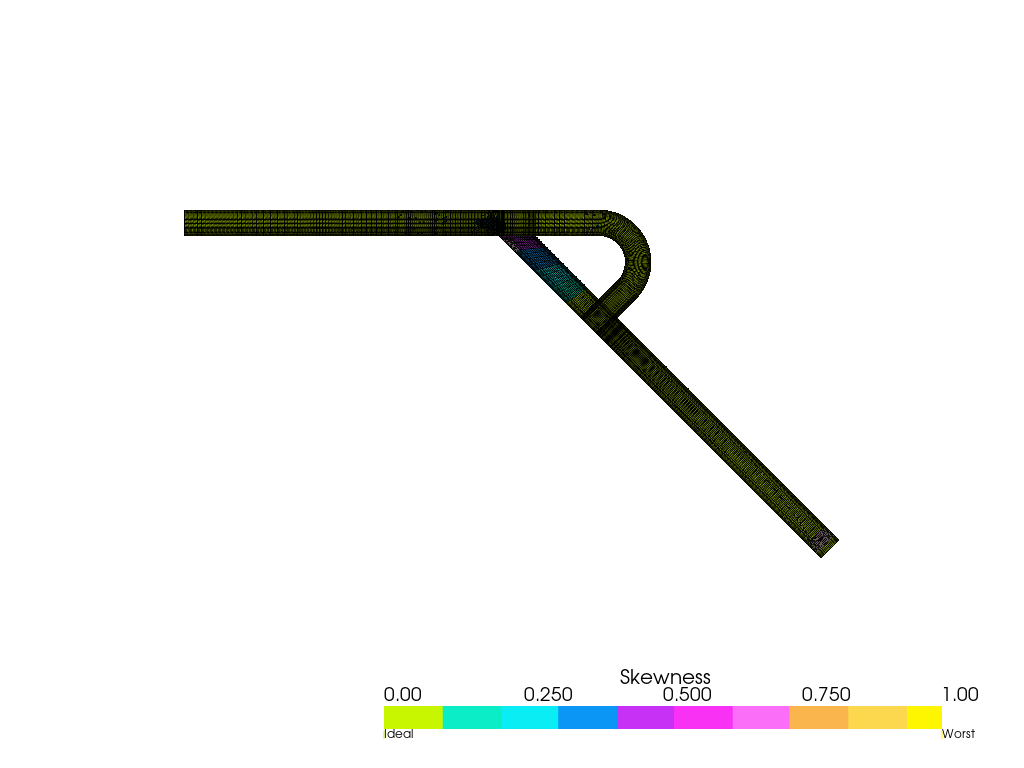

In [21]:
mesh=pv.PolyData(points, cells)
mesh.cell_data['Skewness']= Skewness

# Define the colors we want to use
green = np.array([200/256, 247/256, 0/256, 1])
greenblue = np.array([12/256, 238/256, 200/256, 1])
blue = np.array([12/256, 238/256, 246/256, 1])
darkblue = np.array([12/256, 150/256, 246/256, 1])
purple= np.array([200/256, 50/256, 246/256, 1])
pink= np.array([250/256, 50/256, 246/256, 1])
lightpink = np.array([250/256, 50/256, 246/256, 0.7])
orange = np.array([250/256, 150/256, 0/256, 0.7])
yelloworange = np.array([250/256, 200/256, 0/256, 0.7])
yellow = np.array([255/256, 247/256, 0/256, 1])
grey = np.array([189/256, 189/256, 189/256, 1])

skewness = np.linspace(mesh['Skewness'].min(), mesh['Skewness'].max(), 256)
newcolors = np.empty((256, 4))
newcolors[skewness >= 0] = green
#newcolors[skewness > 0.1] = lightgreen
newcolors[skewness > 0.1] = greenblue
newcolors[skewness > 0.2] = blue
newcolors[skewness > 0.3] = darkblue
newcolors[skewness > 0.4] = purple
newcolors[skewness > 0.5] = pink
newcolors[skewness > 0.6] = lightpink
newcolors[skewness > 0.7] = orange
newcolors[skewness > 0.8] = yelloworange
newcolors[skewness > 0.9] = yellow
newcolors[skewness >= 1] = grey

my_colormap = ListedColormap(newcolors)
annotations = {
    1: "Worst",
    0: "Ideal",
}

pl = pv.Plotter()
pl.set_background('white')
pv.global_theme.font.color = 'black'
pl.add_mesh(mesh, show_edges=True, line_width=0.5,scalars='Skewness',
            cmap=my_colormap, annotations=annotations,clim=[0, 1])
pl.camera_position = 'xy'
pl.show()